# Neural Network

The last model we have chosen was Neural Networks

The reason why we used this model is because since the data set is composed of several features, this model can handle complex relationships between the different features.

# Libraries

Import matplotlib, csv, numpy, and torch.

In [1]:
from DataLoader import DataLoader
from neural_network import NeuralNetwork

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import numpy as np
import torch
import csv
import math

from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

%matplotlib inline

# set default size of plots
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'

torch.manual_seed(0)


%load_ext autoreload
%autoreload 2

### Metric

The metric we will be using is the `precision_score`, since we are mostly just interested in how well the model performs in making predictions.

Gauging the actual Positive/Negative is not as important as precision is a metric that isolates the performance of positive  predictions created by the model. It focuses more on the ratio of correctly predicted positive instances to the total predicted positive instances.

In [2]:
def get_Score(model, X_train, X_test, y_train, y_test, verbose = 1):
    
    #Retrieve the precision score of test & train via sklearn's precision_score
    precision_train = precision_score(model.predict(X_train), y_train, average=None, zero_division = 1)
    precision_test = precision_score(model.predict(X_test), y_test, average=None, zero_division = 1)
    
    #Graph the scores using the graph_Score function if verbose is set to TRUE
    if verbose:
        graph_Scores((precision_train, precision_test))
        
        print(f"Train Avg Precision : {precision_train.mean():.4f}")
        print(f"Test Avg Precision : {precision_test.mean():.4f}")
        
    return precision_train, precision_test

### Graphing & plots
To visualize how our data looks like, we will use matplotlib, for bar and point graphs.

In [3]:
def graph_Scores(scores, title='', ranges = None):
    #Determines the width of each bar in the graph
    width = 0.35

    #X-axis positions for the training and test scores
    br1 = range(len(scores[0])) if ranges is None else ranges
    br2 = [x + width for x in br1] 

    #Create a histogram to visualize the precision scores for the model
    plt.bar(br1, scores[0], width=width, edgecolor='black', label='Train Score')
    plt.bar(br2, scores[1], width=width, edgecolor='black', label='Test Score')
    plt.title(title)
    plt.ylabel('Precision Score')
    plt.xlabel('Class / Genre')

    #Show integers in the x axis accordingly
    plt.xticks(np.arange(0, 11, 1))
    
    plt.legend()
    plt.show()  

## Feature Set up & Splits

### Music Dataset
We will use the music dataset as out dataset. Each instance represents distinct features with the song:
- `Artist Name`       - Name of artist
- `Track Name`        - Name of song
- `Popularity`        - a value between 0 and 100, with 100 being the most popular
- `danceability`      - describes how suitable a track is for dancing
- `energy`            - perceptual measure of intensity and activity
- `key`               - The key the track is in
- `loudness`          - The overall loudness of a track in decibels (dB)
- `mode`              - indicates the modality (major or minor) of a track
- `speechiness`       - detects the presence of spoken words in a track
- `acousticness`      - A measure for whether the track is acoustic
- `instrumentalness`  - Predicts whether a track contains no vocals
- `liveness`          - Detects the presence of an audience in the recording
- `valence`           - Describes the musical positiveness conveyed by a track
- `tempo`             - The overall estimated tempo of a track in beats per minute (BPM)
- `duration_inmin/ms` - Duration in ms
- `time_signature`    - Specifies how many beats are in each bar (or measure)

The songs can be divided into 11 different genres. Upon searching the different songs of the same classes in Google, I as able to determine the 11 classes.
- `Pop`        - class 0
- `Hip-hop`    - class 1
- `Blues`      - class 2
- `Indian-pop` - class 3
- `Country`    - class 4
- `Rap`        - class 5
- `Rock`       - class 6
- `Ambient`    - class 7
- `Metal`      - class 8
- `R&B`        - class 9
- `Indie`      - class 10


### Dataset

In [4]:
df = DataLoader('Dataset 6 - Music Dataset/music.csv', True, True).df['raw']
df

,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration (seconds),Class
0,60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,0.000090,0.0849,0.8990,134.071,234.596,5
1,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251.733,10
2,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109.667,6
3,66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,0.000090,0.1220,0.5690,107.033,173.968,5
4,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229.960,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17991,35.0,0.166,0.109,7.0,-17.100,0,0.0413,0.993000,0.824000,0.0984,0.1770,171.587,193.450,6
17992,27.0,0.638,0.223,11.0,-10.174,0,0.0329,0.858000,0.000016,0.0705,0.3350,73.016,257.067,2
17993,34.0,0.558,0.981,4.0,-4.683,0,0.0712,0.000030,0.000136,0.6660,0.2620,105.000,216.222,8
17994,29.0,0.215,0.805,6.0,-12.757,0,0.1340,0.001290,0.916000,0.2560,0.3550,131.363,219.693,8


We will make the results reproducible by assigning the `random_state` with a random arbitrary value of **42**.

In [5]:
random_state = 42
np.random.seed(random_state)

# 5.0 Setup the features and splits

### Getting batches
This would be used when creating batches whenever we train the network.

In [6]:
def get_batch(X, y, batch_size, mode='train'):
    assert mode in ['train', 'test'], "Mode must be 'train' or 'test'."
    
    indices = np.arange(X.shape[0])
    
    if mode == 'train':
        indices = np.random.permutation(indices)  # Use permutation instead of shuffle to avoid a None assignment
    
    X_batches = []
    y_batches = []
    
    for i in range(0, len(indices), batch_size):
        batch_indices = indices[i:i + batch_size]
        X_batch = X[batch_indices]
        y_batch = y[batch_indices]
        
        X_batches.append(X_batch)
        y_batches.append(y_batch)
    
    return X_batches, y_batches


In [7]:
X = df.drop(columns='Class')
y = df['Class']

print(f'X [{X.shape}] : {X.columns}')
print(f'y [{y.shape}]')

X [(17996, 13)] : Index(['Popularity', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration (seconds)'],
      dtype='object')
y [(17996,)]


### Perform train test split
Set `test_size` to 0.2 and `stratify` to y to ensure proportional sampling.

X_train (14396, 13)
y_train (14396,)
X_test (3600, 13)
y_test (3600,)


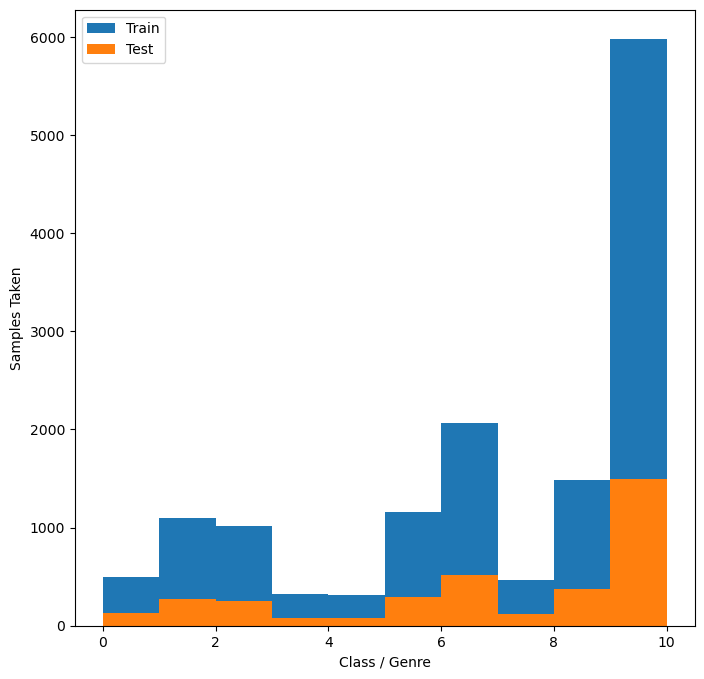

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_state)

print(f'X_train {X_train.shape}')
print(f'y_train {y_train.shape}')
print(f'X_test {X_test.shape}')
print(f'y_test {y_test.shape}')

plt.hist(y_train, label='Train')
plt.hist(y_test, label='Test')
plt.ylabel('Samples Taken')
plt.xlabel('Class / Genre')

plt.legend()
plt.show()

Convert the DataFrame arrays to torch.Tensor. We use torch.Tensor in PyTorch.

In [9]:
# Convert DataFrame to NumPy array
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

# Convert NumPy array into torch.Tensor array
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

# 3.1 Neural Network using ReLU

Instantiation of the Neural Network with the following parameters:
- `Input` - 13
- `Output` - 11
- `Hidden layers` - 2
- `list_hidden` - (50, 100)
- `activation` - relu
- `weight initialization` - default
- `Verbose` - 1

In [10]:
relu_network = NeuralNetwork(13, 11, list_hidden=(50, 100), activation='relu')
relu_network.create_network()
relu_network.init_weights()
relu_network.forward(X_train, verbose = True)

Output of layer 0
tensor([[ 0.1475, -0.4938, -0.1937,  ..., -3.8789,  0.6792,  2.2372],
        [ 1.2111, -0.2940, -0.3726,  ..., -5.4792,  1.9788,  2.5446],
        [ 0.7303, -0.5261, -0.2345,  ..., -4.4956,  1.5119,  2.2154],
        ...,
        [ 1.2040, -0.6735, -0.4146,  ..., -6.7156,  2.2548,  3.2224],
        [-0.3996,  0.3590,  0.0568,  ..., -0.7085, -0.4525,  0.8479],
        [ 0.5766, -0.5375, -0.1603,  ..., -3.8921,  1.3264,  1.9394]],
       grad_fn=<AddmmBackward0>) 

Output of layer 1
tensor([[0.5368, 0.3790, 0.4517,  ..., 0.0203, 0.6636, 0.9035],
        [0.7705, 0.4270, 0.4079,  ..., 0.0042, 0.8785, 0.9272],
        [0.6749, 0.3714, 0.4416,  ..., 0.0110, 0.8193, 0.9016],
        ...,
        [0.7692, 0.3377, 0.3978,  ..., 0.0012, 0.9051, 0.9617],
        [0.4014, 0.5888, 0.5142,  ..., 0.3299, 0.3888, 0.7001],
        [0.6403, 0.3688, 0.4600,  ..., 0.0200, 0.7902, 0.8743]],
       grad_fn=<SigmoidBackward0>) 

Output of layer 2
tensor([[-0.0204,  0.0031, -0.0689,  ..., 

(tensor([[-1.2165e-03, -1.8279e-03,  6.3191e-04,  ..., -2.2150e-04,
           5.2239e-04,  6.7562e-04],
         [-1.3186e-03, -1.8633e-03,  1.1859e-03,  ..., -5.3731e-04,
           1.1288e-03, -1.2877e-04],
         [-1.1365e-03, -1.8068e-03,  9.4798e-04,  ..., -2.0948e-04,
           1.0527e-03,  3.9424e-04],
         ...,
         [-1.0042e-03, -1.7087e-03,  5.0276e-04,  ..., -3.8807e-04,
           7.9736e-04,  1.6702e-04],
         [-1.3818e-03, -1.3864e-03,  2.6068e-03,  ..., -5.9301e-04,
           1.5401e-03,  8.6987e-05],
         [-1.1233e-03, -1.9094e-03,  1.0614e-03,  ..., -1.3512e-04,
           1.1658e-03,  4.5758e-04]], grad_fn=<AddmmBackward0>),
 tensor([[0.0908, 0.0907, 0.0909,  ..., 0.0909, 0.0909, 0.0909],
         [0.0908, 0.0907, 0.0910,  ..., 0.0908, 0.0910, 0.0909],
         [0.0908, 0.0907, 0.0910,  ..., 0.0909, 0.0910, 0.0909],
         ...,
         [0.0908, 0.0907, 0.0909,  ..., 0.0908, 0.0910, 0.0909],
         [0.0908, 0.0908, 0.0911,  ..., 0.0908, 0.0910

### Getting the predictions


In [11]:
np.random.seed(random_state)
random_indices = np.random.randint(X_train.shape[0], 
                                   size=10)

relu_scores, probabilities = relu_network.forward(X_train[random_indices])

Well use Adam as the optimizer with the following parameters:
- `params` - the parameters of the network
- `lr` = 0.001

In [12]:
optimizer = optim.Adam(relu_network.parameters(), 0.001)
target_classes = torch.Tensor(y_train[random_indices]).long()

Then instantiated a nn.CrossEntropyLoss() object to get the loss.

In [13]:
criterion = nn.CrossEntropyLoss()
loss = criterion(relu_scores, target_classes)

Then we update the gradients and weights of the nerwork.

In [14]:
# Clear gradients
optimizer.zero_grad()

# Using Backwards Propagation get the gradients
loss.backward()

# Update the weights
optimizer.step()

## Training the network

In [15]:
e = 0
max_epochs = 300
is_converged = False
previous_loss = 0
losses = []

# For each epoch
while e < max_epochs and is_converged is not True:
    
    current_epoch_loss = 0
    
    # Seperate training set into batches
    X_batch, y_batch = get_batch(X_train, y_train, 128, mode='train')
    
    # For each batch
    for X, y in zip(X_batch, y_batch):
        X = torch.Tensor(X)
        y = torch.Tensor(y).to(torch.long)

        optimizer.zero_grad()

        relu_scores, probabilities = relu_network.forward(X)
        
        loss = criterion(relu_scores, y)
        
        loss.backward()
        
        optimizer.step()
        
        current_epoch_loss += loss.item()
    
    average_loss = current_epoch_loss / len(X_batch)
    losses.append(average_loss)
    
    # Display the average loss per epoch
    print('Epoch:', e + 1, '\tLoss: {:.6f}'.format(average_loss))
    
    if abs(previous_loss - loss) < 0.00000005:
        is_converged = True
    else:
        previous_loss = loss
        e += 1

Epoch: 1 	Loss: 1.999957
Epoch: 2 	Loss: 1.832006
Epoch: 3 	Loss: 1.817018
Epoch: 4 	Loss: 1.774965
Epoch: 5 	Loss: 1.715967
Epoch: 6 	Loss: 1.686904
Epoch: 7 	Loss: 1.660253
Epoch: 8 	Loss: 1.623483
Epoch: 9 	Loss: 1.598093
Epoch: 10 	Loss: 1.574913
Epoch: 11 	Loss: 1.558615
Epoch: 12 	Loss: 1.539547
Epoch: 13 	Loss: 1.519784
Epoch: 14 	Loss: 1.506182
Epoch: 15 	Loss: 1.489997
Epoch: 16 	Loss: 1.489627
Epoch: 17 	Loss: 1.473520
Epoch: 18 	Loss: 1.466735
Epoch: 19 	Loss: 1.463047
Epoch: 20 	Loss: 1.453709
Epoch: 21 	Loss: 1.443555
Epoch: 22 	Loss: 1.435500
Epoch: 23 	Loss: 1.438260
Epoch: 24 	Loss: 1.427517
Epoch: 25 	Loss: 1.423875
Epoch: 26 	Loss: 1.414952
Epoch: 27 	Loss: 1.409653
Epoch: 28 	Loss: 1.406514
Epoch: 29 	Loss: 1.401825
Epoch: 30 	Loss: 1.399696
Epoch: 31 	Loss: 1.394618
Epoch: 32 	Loss: 1.388531
Epoch: 33 	Loss: 1.388152
Epoch: 34 	Loss: 1.389592
Epoch: 35 	Loss: 1.382019
Epoch: 36 	Loss: 1.377927
Epoch: 37 	Loss: 1.380518
Epoch: 38 	Loss: 1.370225
Epoch: 39 	Loss: 1.36

Visualizing the lost per training epoch. 

Text(0.5, 1.0, 'Loss for each training epoch')

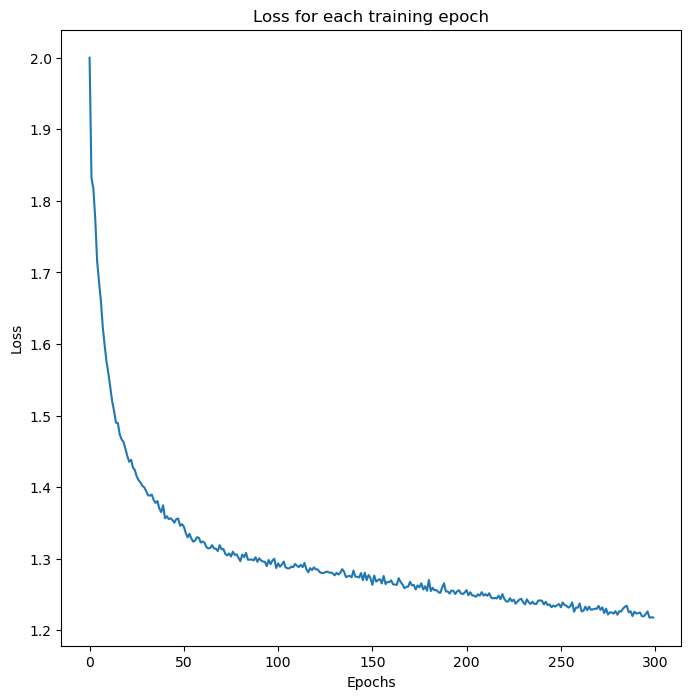

In [16]:
x_values = [i for i in range(len(losses))]
y_values = losses

plt.plot(x_values, y_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss for each training epoch')

### Trying out the trained network on the test data
Setting it to eval mode first to avoid updating the weights.

In [17]:
relu_network.eval()

NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=13, out_features=50, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=50, out_features=100, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=100, out_features=11, bias=True)
    (5): Softmax(dim=1)
  )
)

Then perform forwad propagation on the test data and get the prediction results.

In [18]:
relu_scores,probabilities = relu_network.forward(X_test);
predictions = relu_network.predict(probabilities)
print("Predictions: ", predictions)

Predictions:  tensor([ 3,  6, 10,  ..., 10, 10,  8])


Get the accuracy of the network

In [19]:
relu_accuracy = accuracy_score(y_test,predictions)
print("Accuracy: ", relu_accuracy)

Accuracy:  0.5208333333333334


Get the precision of the network.

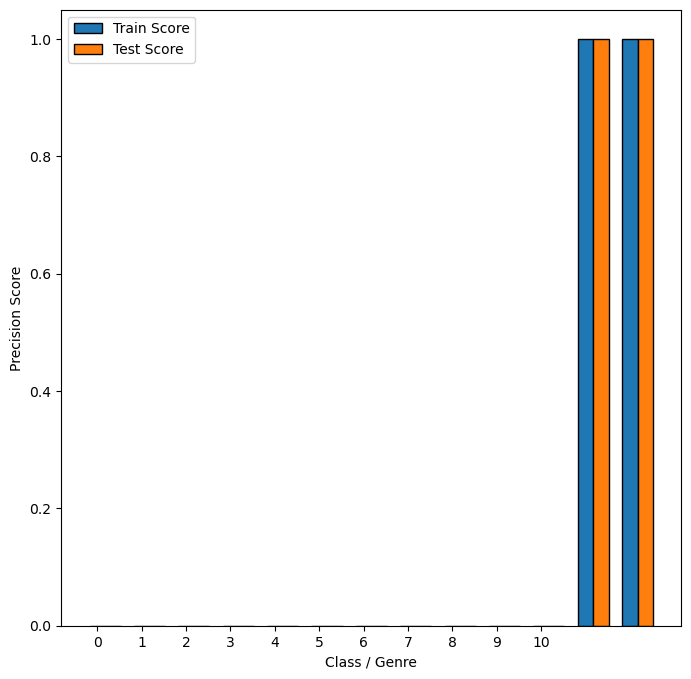

Train Avg Precision : 0.1538
Test Avg Precision : 0.1538


In [20]:
precision = get_Score(relu_network, X_train, X_test, y_train, y_test, verbose = 1)

# 3.2 ReLU vs. ELU
We do the same steps as the previous network but we change the activation function to `ELU` and then compare which is better. 

Instantiation of the Neural Network with the following parameters:
- `Input` - 13
- `Output` - 11
- `Hidden layers` - 2
- `list_hidden` - (50, 100)
- `activation` - ELU
- `weight initialization` - default
- `Verbose` - 1

In [21]:
elu_network = NeuralNetwork(13, 11, list_hidden=(50, 100), activation='elu')
elu_network.create_network()
elu_network.init_weights()
elu_network.forward(X_train, verbose = True)

Output of layer 0
tensor([[ 0.1475, -0.4938, -0.1937,  ..., -3.8789,  0.6792,  2.2372],
        [ 1.2111, -0.2940, -0.3726,  ..., -5.4792,  1.9788,  2.5446],
        [ 0.7303, -0.5261, -0.2345,  ..., -4.4956,  1.5119,  2.2154],
        ...,
        [ 1.2040, -0.6735, -0.4146,  ..., -6.7156,  2.2548,  3.2224],
        [-0.3996,  0.3590,  0.0568,  ..., -0.7085, -0.4525,  0.8479],
        [ 0.5766, -0.5375, -0.1603,  ..., -3.8921,  1.3264,  1.9394]],
       grad_fn=<AddmmBackward0>) 

Output of layer 1
tensor([[0.5368, 0.3790, 0.4517,  ..., 0.0203, 0.6636, 0.9035],
        [0.7705, 0.4270, 0.4079,  ..., 0.0042, 0.8785, 0.9272],
        [0.6749, 0.3714, 0.4416,  ..., 0.0110, 0.8193, 0.9016],
        ...,
        [0.7692, 0.3377, 0.3978,  ..., 0.0012, 0.9051, 0.9617],
        [0.4014, 0.5888, 0.5142,  ..., 0.3299, 0.3888, 0.7001],
        [0.6403, 0.3688, 0.4600,  ..., 0.0200, 0.7902, 0.8743]],
       grad_fn=<SigmoidBackward0>) 

Output of layer 2
tensor([[-0.0204,  0.0031, -0.0689,  ..., 

(tensor([[-2.7004e-03,  1.6827e-05,  8.0043e-05,  ...,  6.9814e-04,
           2.9374e-03, -3.3487e-04],
         [-2.7711e-03,  4.1494e-04,  3.0950e-04,  ...,  1.9957e-04,
           3.4212e-03, -2.2869e-03],
         [-2.7004e-03,  2.7128e-04, -1.6213e-04,  ...,  5.8363e-04,
           3.1518e-03, -1.5607e-03],
         ...,
         [-2.6316e-03,  1.1858e-04, -6.2925e-04,  ...,  3.7963e-04,
           3.1195e-03, -1.8516e-03],
         [-2.7551e-03,  9.1957e-04,  2.8521e-03,  ...,  5.4127e-05,
           2.8595e-03, -6.1282e-04],
         [-2.6912e-03,  2.6462e-04, -1.3273e-04,  ...,  6.3364e-04,
           3.0359e-03, -1.5606e-03]], grad_fn=<AddmmBackward0>),
 tensor([[0.0906, 0.0909, 0.0909,  ..., 0.0909, 0.0911, 0.0908],
         [0.0906, 0.0909, 0.0909,  ..., 0.0909, 0.0912, 0.0907],
         [0.0906, 0.0909, 0.0909,  ..., 0.0909, 0.0912, 0.0908],
         ...,
         [0.0907, 0.0909, 0.0908,  ..., 0.0909, 0.0912, 0.0907],
         [0.0906, 0.0910, 0.0911,  ..., 0.0909, 0.0912

In [22]:
np.random.seed(random_state)
random_indices = np.random.randint(X_train.shape[0], 
                                   size=10)

elu_scores, probabilities = elu_network.forward(X_train[random_indices])

In [23]:
optimizer = optim.Adam(elu_network.parameters(), 0.001)
target_classes = torch.Tensor(y_train[random_indices]).long()

In [24]:
criterion = nn.CrossEntropyLoss()
loss = criterion(elu_scores, target_classes)

In [25]:
optimizer.zero_grad()
loss.backward()
optimizer.step()

In [26]:
e = 0
max_epochs = 300
is_converged = False
previous_loss = 0
losses = []

# For each epoch
while e < max_epochs and is_converged is not True:
    
    current_epoch_loss = 0
    
    # Seperate training set into batches
    X_batch, y_batch = get_batch(X_train, y_train, 128, mode='train')
    
    # For each batch
    for X, y in zip(X_batch, y_batch):
        X = torch.Tensor(X)
        y = torch.Tensor(y).to(torch.long)

        optimizer.zero_grad()

        elu_scores, probabilities = elu_network.forward(X)
        
        loss = criterion(elu_scores, y)
        
        loss.backward()
        
        optimizer.step()
        
        current_epoch_loss += loss.item()
    
    average_loss = current_epoch_loss / len(X_batch)
    losses.append(average_loss)
    
    # Display the average loss per epoch
    print('Epoch:', e + 1, '\tLoss: {:.6f}'.format(average_loss))
    
    if abs(previous_loss - loss) < 0.00000005:
        is_converged = True
    else:
        previous_loss = loss
        e += 1

Epoch: 1 	Loss: 1.966517
Epoch: 2 	Loss: 1.835284
Epoch: 3 	Loss: 1.760328
Epoch: 4 	Loss: 1.710558
Epoch: 5 	Loss: 1.669432
Epoch: 6 	Loss: 1.632710
Epoch: 7 	Loss: 1.615471
Epoch: 8 	Loss: 1.586246
Epoch: 9 	Loss: 1.568506
Epoch: 10 	Loss: 1.546036
Epoch: 11 	Loss: 1.520680
Epoch: 12 	Loss: 1.503984
Epoch: 13 	Loss: 1.482701
Epoch: 14 	Loss: 1.468137
Epoch: 15 	Loss: 1.447443
Epoch: 16 	Loss: 1.465829
Epoch: 17 	Loss: 1.454431
Epoch: 18 	Loss: 1.436048
Epoch: 19 	Loss: 1.431879
Epoch: 20 	Loss: 1.419649
Epoch: 21 	Loss: 1.401045
Epoch: 22 	Loss: 1.394481
Epoch: 23 	Loss: 1.389330
Epoch: 24 	Loss: 1.381170
Epoch: 25 	Loss: 1.380451
Epoch: 26 	Loss: 1.363813
Epoch: 27 	Loss: 1.367689
Epoch: 28 	Loss: 1.361104
Epoch: 29 	Loss: 1.351103
Epoch: 30 	Loss: 1.359551
Epoch: 31 	Loss: 1.347109
Epoch: 32 	Loss: 1.347022
Epoch: 33 	Loss: 1.346521
Epoch: 34 	Loss: 1.345378
Epoch: 35 	Loss: 1.335523
Epoch: 36 	Loss: 1.334978
Epoch: 37 	Loss: 1.341910
Epoch: 38 	Loss: 1.333603
Epoch: 39 	Loss: 1.32

Text(0.5, 1.0, 'Loss for each training epoch')

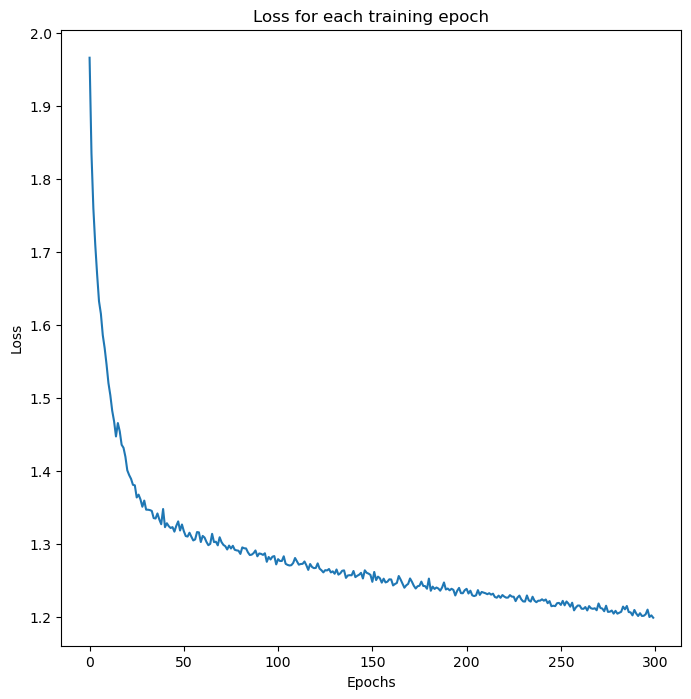

In [27]:
x_values = [i for i in range(len(losses))]
y_values = losses

plt.plot(x_values, y_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss for each training epoch')

In [28]:
elu_network.eval()

NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=13, out_features=50, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=50, out_features=100, bias=True)
    (3): ELU(alpha=1.0, inplace=True)
    (4): Linear(in_features=100, out_features=11, bias=True)
    (5): Softmax(dim=1)
  )
)

In [29]:
elu_scores,probabilities = elu_network.forward(X_test)
elu_predictions = elu_network.predict(probabilities)
print("Predictions: ", predictions)

Predictions:  tensor([ 3,  6, 10,  ..., 10, 10,  8])


In [30]:
elu_accuracy = accuracy_score(y_test,elu_predictions)
print("Accuracy: ", elu_accuracy)

Accuracy:  0.5166666666666667


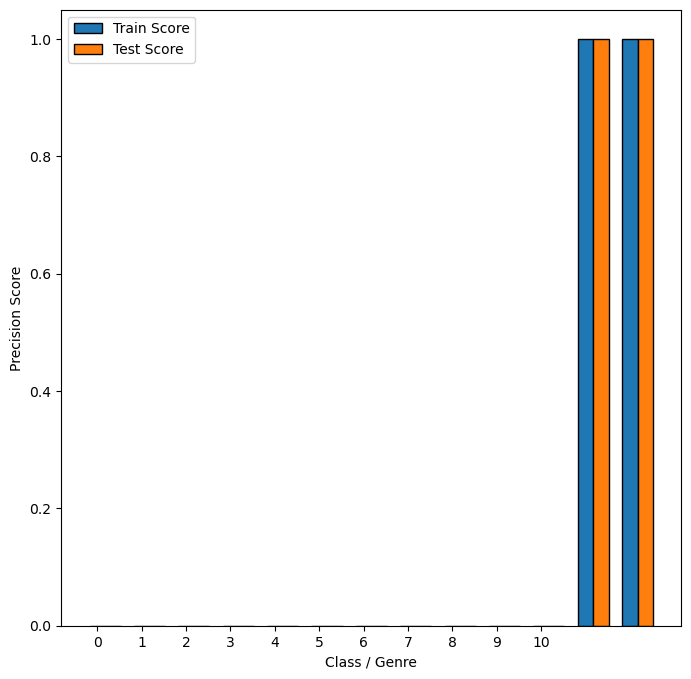

Train Avg Precision : 0.1538
Test Avg Precision : 0.1538


In [31]:
precision = get_Score(elu_network, X_train, X_test, y_train, y_test, verbose = 0)

### Comparison for ReLU and ELU

Here we can see that the accuracy of the network got worse by changing the activation fuction from `ReLU` to `ELU`. Because of this we will continue with ReLU as our activation function.

From 52.08% to 51.42%

In [32]:
print("Accuracy ReLU: ", relu_accuracy)
print("Accuracy ELU: ", elu_accuracy)

Accuracy ReLU:  0.5208333333333334
Accuracy ELU:  0.5166666666666667


# 3.3 Neural Network using ReLU with Weight Initialization
To see if the loss has really reached the lowest value for convergence, we tested if weight initialization would be able to bring it lower. Since ELU had a better accuracy compared to ReLU, we will using it for this section. 

Instantiation of the Neural Network with the following parameters:
- `Input` - 13
- `Output` - 11
- `Hidden layers` - 2
- `list_hidden` - (50, 100)
- `activation` - ReLU
- `weight initialization` - xavier
- `Verbose` - 1

In [33]:
xavier_network = NeuralNetwork(13, 11, list_hidden=(50, 100), activation='relu', init_method='xavier')
xavier_network.create_network()
xavier_network.init_weights()
xavier_network.forward(X_train, verbose = True)

Output of layer 0
tensor([[   2.6280,   -8.7984,   -3.4506,  ...,  -69.1112,   12.1010,
           39.8609],
        [  21.5786,   -5.2384,   -6.6396,  ...,  -97.6259,   35.2564,
           45.3382],
        [  13.0125,   -9.3742,   -4.1779,  ...,  -80.1003,   26.9387,
           39.4725],
        ...,
        [  21.4523,  -11.9994,   -7.3873,  ..., -119.6552,   40.1753,
           57.4144],
        [  -7.1197,    6.3970,    1.0123,  ...,  -12.6232,   -8.0618,
           15.1081],
        [  10.2742,   -9.5769,   -2.8563,  ...,  -69.3473,   23.6326,
           34.5545]], grad_fn=<AddmmBackward0>) 

Output of layer 1
tensor([[9.3264e-01, 1.5095e-04, 3.0751e-02,  ..., 9.6694e-31, 9.9999e-01,
         1.0000e+00],
        [1.0000e+00, 5.2807e-03, 1.3059e-03,  ..., 0.0000e+00, 1.0000e+00,
         1.0000e+00],
        [1.0000e+00, 8.4880e-05, 1.5099e-02,  ..., 1.6327e-35, 1.0000e+00,
         1.0000e+00],
        ...,
        [1.0000e+00, 6.1481e-06, 6.1865e-04,  ..., 0.0000e+00, 1.0000e+0

(tensor([[-0.0413, -0.3033, -0.1642,  ..., -0.2669, -0.1462,  0.0176],
         [-0.0798, -0.4674, -0.1552,  ..., -0.3361, -0.0390, -0.4830],
         [-0.1513, -0.3926, -0.2312,  ..., -0.1332, -0.0410, -0.1212],
         ...,
         [-0.1408, -0.4387, -0.2484,  ..., -0.1298, -0.0535, -0.1536],
         [-0.1067, -0.2783,  0.2767,  ..., -0.0235,  0.2731, -0.1297],
         [-0.1331, -0.4313, -0.2414,  ..., -0.1287, -0.0523, -0.1414]],
        grad_fn=<AddmmBackward0>),
 tensor([[0.0740, 0.0569, 0.0654,  ..., 0.0590, 0.0666, 0.0785],
         [0.0798, 0.0541, 0.0740,  ..., 0.0617, 0.0831, 0.0533],
         [0.0671, 0.0527, 0.0620,  ..., 0.0683, 0.0749, 0.0692],
         ...,
         [0.0680, 0.0505, 0.0611,  ..., 0.0688, 0.0742, 0.0671],
         [0.0675, 0.0569, 0.0991,  ..., 0.0734, 0.0987, 0.0660],
         [0.0684, 0.0507, 0.0614,  ..., 0.0687, 0.0741, 0.0678]],
        grad_fn=<SoftmaxBackward0>))

In [34]:
np.random.seed(random_state)
random_indices = np.random.randint(X_train.shape[0], 
                                   size=10)

xavier_scores, probabilities = xavier_network.forward(X_train[random_indices])

In [35]:
optimizer = optim.Adam(xavier_network.parameters(), 0.001)
target_classes = torch.Tensor(y_train[random_indices]).long()

In [36]:
criterion = nn.CrossEntropyLoss()
loss = criterion(xavier_scores, target_classes)

In [37]:
optimizer.zero_grad()
loss.backward()
optimizer.step()

In [38]:
e = 0
max_epochs = 300
is_converged = False
previous_loss = 0
losses = []

# For each epoch
while e < max_epochs and is_converged is not True:
    
    current_epoch_loss = 0
    
    # Seperate training set into batches
    X_batch, y_batch = get_batch(X_train, y_train, 128, mode='train')
    
    # For each batch
    for X, y in zip(X_batch, y_batch):
        X = torch.Tensor(X)
        y = torch.Tensor(y).to(torch.long)

        optimizer.zero_grad()

        xavier_scores, probabilities = xavier_network.forward(X)
        
        loss = criterion(xavier_scores, y)
        
        loss.backward()
        
        optimizer.step()
        
        current_epoch_loss += loss.item()
    
    average_loss = current_epoch_loss / len(X_batch)
    losses.append(average_loss)
    
    # Display the average loss per epoch
    print('Epoch:', e + 1, '\tLoss: {:.6f}'.format(average_loss))
    
    if abs(previous_loss - loss) < 0.00000005:
        is_converged = True
    else:
        previous_loss = loss
        e += 1

Epoch: 1 	Loss: 1.951974
Epoch: 2 	Loss: 1.746816
Epoch: 3 	Loss: 1.695265
Epoch: 4 	Loss: 1.667704
Epoch: 5 	Loss: 1.647076
Epoch: 6 	Loss: 1.633866
Epoch: 7 	Loss: 1.621988
Epoch: 8 	Loss: 1.607693
Epoch: 9 	Loss: 1.597888
Epoch: 10 	Loss: 1.584131
Epoch: 11 	Loss: 1.573071
Epoch: 12 	Loss: 1.551590
Epoch: 13 	Loss: 1.534708
Epoch: 14 	Loss: 1.512220
Epoch: 15 	Loss: 1.494849
Epoch: 16 	Loss: 1.484695
Epoch: 17 	Loss: 1.468174
Epoch: 18 	Loss: 1.457782
Epoch: 19 	Loss: 1.449465
Epoch: 20 	Loss: 1.442787
Epoch: 21 	Loss: 1.434167
Epoch: 22 	Loss: 1.419948
Epoch: 23 	Loss: 1.427287
Epoch: 24 	Loss: 1.410631
Epoch: 25 	Loss: 1.409426
Epoch: 26 	Loss: 1.399908
Epoch: 27 	Loss: 1.393531
Epoch: 28 	Loss: 1.392279
Epoch: 29 	Loss: 1.387639
Epoch: 30 	Loss: 1.381342
Epoch: 31 	Loss: 1.376613
Epoch: 32 	Loss: 1.366118
Epoch: 33 	Loss: 1.364097
Epoch: 34 	Loss: 1.362855
Epoch: 35 	Loss: 1.359961
Epoch: 36 	Loss: 1.353153
Epoch: 37 	Loss: 1.357701
Epoch: 38 	Loss: 1.346419
Epoch: 39 	Loss: 1.33

Text(0.5, 1.0, 'Loss for each training epoch')

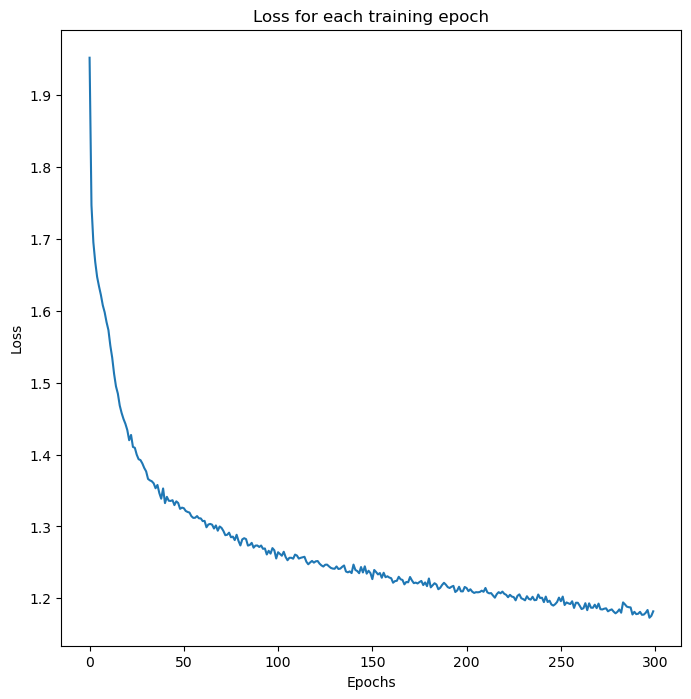

In [39]:
x_values = [i for i in range(len(losses))]
y_values = losses

plt.plot(x_values, y_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss for each training epoch')

In [40]:
xavier_network.eval()

NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=13, out_features=50, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=50, out_features=100, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=100, out_features=11, bias=True)
    (5): Softmax(dim=1)
  )
)

In [41]:
xavier_scores,probabilities = xavier_network.forward(X_test);
xavier_predictions = xavier_network.predict(probabilities)
print("Predictions: ", xavier_predictions)

Predictions:  tensor([ 3,  6, 10,  ...,  2, 10,  8])


In [42]:
xavier_accuracy = accuracy_score(y_test,xavier_predictions)
print("Accuracy: ", xavier_accuracy)

Accuracy:  0.5183333333333333


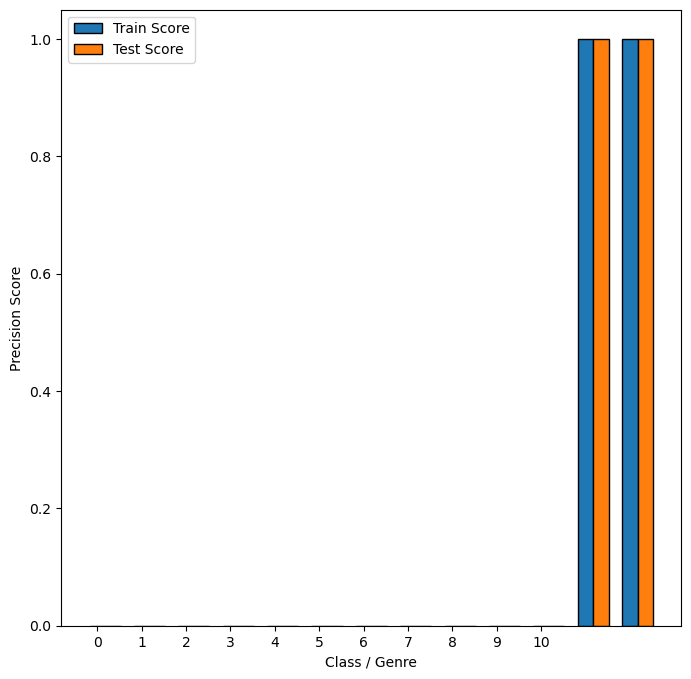

Train Avg Precision : 0.1538
Test Avg Precision : 0.1538


In [43]:
precision = get_Score(xavier_network, X_train, X_test, y_train, y_test, verbose = 0)

### Comparison for ReLU,  ELU, and Xavier + ReLU 
Here we can see that by adding weight initialization the accuracy of the predictions got worse compared to having a default weight initialization. Because of this we will use the default weigh initialization values which are mean=0.0 and std=0.01.

From 52.08% to 51.83%

In [44]:
print('ReLU Accuracy: ', relu_accuracy)
print('ELU Accuracy: ', elu_accuracy)
print('Xavier + ReLU Accuracy: ', xavier_accuracy)

ReLU Accuracy:  0.5208333333333334
ELU Accuracy:  0.5166666666666667
Xavier + ReLU Accuracy:  0.5183333333333333


### Additional
When experimenting with another weight initialization technique, to be specific `Kaiming` initialization. The accuracy was 00.91% lower than when we used `Xavier` initialization. 

For reference this was the computed values for both Xavier and Kaiming initialization.

`Xavier`: 0.5183333333333333

`Kaiming`: 0.5091666666666667

# 3.4 Neural Network with additional tweaking

**Changes:**
Here we adjusted certain parts to try to increase the accuracy of the ReLU network. 
This was done by adjusting the following:
- `epochs during training` - from 300 -> 500
- `batch sizes` - from 128 -> 64

The reason why we chose 500 epochs is because when testing different values for the epochs, any value above 500 tends to have either the same or similar results to 500 epochs. With the diminishing returns in mind, we used 500 epochs since that was the value where the outputs stop having significant changes.  

As for the reason why we decreased the batch sizes, this is because by decreasing the batch sizes we can have a more stable and more generalizable updates. 

Instantiation of the Neural Network with the following parameters:
- `Input` - 13
- `Output` - 11
- `Hidden layers` - 5
- `list_hidden` - (50, 100)
- `activation` - relu
- `weight initialization` - default
- `Verbose` - 1

In [45]:
network = NeuralNetwork(13, 11, list_hidden=(50, 100), activation='relu')
network.create_network()
network.init_weights()
network.forward(X_train, verbose = True)

Output of layer 0
tensor([[ 0.1475, -0.4938, -0.1937,  ..., -3.8789,  0.6792,  2.2372],
        [ 1.2111, -0.2940, -0.3726,  ..., -5.4792,  1.9788,  2.5446],
        [ 0.7303, -0.5261, -0.2345,  ..., -4.4956,  1.5119,  2.2154],
        ...,
        [ 1.2040, -0.6735, -0.4146,  ..., -6.7156,  2.2548,  3.2224],
        [-0.3996,  0.3590,  0.0568,  ..., -0.7085, -0.4525,  0.8479],
        [ 0.5766, -0.5375, -0.1603,  ..., -3.8921,  1.3264,  1.9394]],
       grad_fn=<AddmmBackward0>) 

Output of layer 1
tensor([[0.5368, 0.3790, 0.4517,  ..., 0.0203, 0.6636, 0.9035],
        [0.7705, 0.4270, 0.4079,  ..., 0.0042, 0.8785, 0.9272],
        [0.6749, 0.3714, 0.4416,  ..., 0.0110, 0.8193, 0.9016],
        ...,
        [0.7692, 0.3377, 0.3978,  ..., 0.0012, 0.9051, 0.9617],
        [0.4014, 0.5888, 0.5142,  ..., 0.3299, 0.3888, 0.7001],
        [0.6403, 0.3688, 0.4600,  ..., 0.0200, 0.7902, 0.8743]],
       grad_fn=<SigmoidBackward0>) 

Output of layer 2
tensor([[-0.0204,  0.0031, -0.0689,  ..., 

(tensor([[-1.2165e-03, -1.8279e-03,  6.3191e-04,  ..., -2.2150e-04,
           5.2239e-04,  6.7562e-04],
         [-1.3186e-03, -1.8633e-03,  1.1859e-03,  ..., -5.3731e-04,
           1.1288e-03, -1.2877e-04],
         [-1.1365e-03, -1.8068e-03,  9.4798e-04,  ..., -2.0948e-04,
           1.0527e-03,  3.9424e-04],
         ...,
         [-1.0042e-03, -1.7087e-03,  5.0276e-04,  ..., -3.8807e-04,
           7.9736e-04,  1.6702e-04],
         [-1.3818e-03, -1.3864e-03,  2.6068e-03,  ..., -5.9301e-04,
           1.5401e-03,  8.6987e-05],
         [-1.1233e-03, -1.9094e-03,  1.0614e-03,  ..., -1.3512e-04,
           1.1658e-03,  4.5758e-04]], grad_fn=<AddmmBackward0>),
 tensor([[0.0908, 0.0907, 0.0909,  ..., 0.0909, 0.0909, 0.0909],
         [0.0908, 0.0907, 0.0910,  ..., 0.0908, 0.0910, 0.0909],
         [0.0908, 0.0907, 0.0910,  ..., 0.0909, 0.0910, 0.0909],
         ...,
         [0.0908, 0.0907, 0.0909,  ..., 0.0908, 0.0910, 0.0909],
         [0.0908, 0.0908, 0.0911,  ..., 0.0908, 0.0910

### Getting the predictions

In [46]:
np.random.seed(random_state)
random_indices = np.random.randint(X_train.shape[0], 
                                   size=10)

scores, probabilities = network.forward(X_train[random_indices])

In [47]:
optimizer = optim.Adam(network.parameters(), 0.001)
target_classes = torch.Tensor(y_train[random_indices]).long()

In [48]:
criterion = nn.CrossEntropyLoss()
loss = criterion(scores, target_classes)

In [49]:
# Clear gradients
optimizer.zero_grad()

# Using Backwards Propagation get the gradients
loss.backward()

# Update the weights
optimizer.step()

### Training the network

In [50]:
e = 0
max_epochs = 500
is_converged = False
previous_loss = 0
losses = []

# For each epoch
while e < max_epochs and is_converged is not True:
    
    current_epoch_loss = 0
    
    # Seperate training set into batches
    X_batch, y_batch = get_batch(X_train, y_train, 64, mode='train')
    
    # For each batch
    for X, y in zip(X_batch, y_batch):
        X = torch.Tensor(X)
        y = torch.Tensor(y).to(torch.long)

        optimizer.zero_grad()

        relu_scores, probabilities = network.forward(X)
        
        loss = criterion(relu_scores, y)
        
        loss.backward()
        
        optimizer.step()
        
        current_epoch_loss += loss.item()
    
    average_loss = current_epoch_loss / len(X_batch)
    losses.append(average_loss)
    
    # Display the average loss per epoch
    print('Epoch:', e + 1, '\tLoss: {:.6f}'.format(average_loss))
    
    if abs(previous_loss - loss) < 0.00000005:
        is_converged = True
    else:
        previous_loss = loss
        e += 1

Epoch: 1 	Loss: 1.921209
Epoch: 2 	Loss: 1.769436
Epoch: 3 	Loss: 1.712491
Epoch: 4 	Loss: 1.672695
Epoch: 5 	Loss: 1.617088
Epoch: 6 	Loss: 1.595269
Epoch: 7 	Loss: 1.568427
Epoch: 8 	Loss: 1.548790
Epoch: 9 	Loss: 1.531922
Epoch: 10 	Loss: 1.511269
Epoch: 11 	Loss: 1.493866
Epoch: 12 	Loss: 1.482903
Epoch: 13 	Loss: 1.467607
Epoch: 14 	Loss: 1.461097
Epoch: 15 	Loss: 1.447907
Epoch: 16 	Loss: 1.443743
Epoch: 17 	Loss: 1.436186
Epoch: 18 	Loss: 1.419628
Epoch: 19 	Loss: 1.419393
Epoch: 20 	Loss: 1.410451
Epoch: 21 	Loss: 1.401091
Epoch: 22 	Loss: 1.402293
Epoch: 23 	Loss: 1.389904
Epoch: 24 	Loss: 1.383319
Epoch: 25 	Loss: 1.380831
Epoch: 26 	Loss: 1.377366
Epoch: 27 	Loss: 1.376259
Epoch: 28 	Loss: 1.370141
Epoch: 29 	Loss: 1.360113
Epoch: 30 	Loss: 1.360494
Epoch: 31 	Loss: 1.357541
Epoch: 32 	Loss: 1.350495
Epoch: 33 	Loss: 1.351039
Epoch: 34 	Loss: 1.344040
Epoch: 35 	Loss: 1.345757
Epoch: 36 	Loss: 1.332265
Epoch: 37 	Loss: 1.336285
Epoch: 38 	Loss: 1.333503
Epoch: 39 	Loss: 1.33

Epoch: 309 	Loss: 1.175301
Epoch: 310 	Loss: 1.176059
Epoch: 311 	Loss: 1.179503
Epoch: 312 	Loss: 1.172580
Epoch: 313 	Loss: 1.179511
Epoch: 314 	Loss: 1.176333
Epoch: 315 	Loss: 1.174763
Epoch: 316 	Loss: 1.171103
Epoch: 317 	Loss: 1.171057
Epoch: 318 	Loss: 1.174236
Epoch: 319 	Loss: 1.174238
Epoch: 320 	Loss: 1.171044
Epoch: 321 	Loss: 1.174235
Epoch: 322 	Loss: 1.176922
Epoch: 323 	Loss: 1.176011
Epoch: 324 	Loss: 1.172366
Epoch: 325 	Loss: 1.174454
Epoch: 326 	Loss: 1.181535
Epoch: 327 	Loss: 1.170248
Epoch: 328 	Loss: 1.169127
Epoch: 329 	Loss: 1.170154
Epoch: 330 	Loss: 1.171202
Epoch: 331 	Loss: 1.172957
Epoch: 332 	Loss: 1.168408
Epoch: 333 	Loss: 1.170899
Epoch: 334 	Loss: 1.176151
Epoch: 335 	Loss: 1.167560
Epoch: 336 	Loss: 1.167443
Epoch: 337 	Loss: 1.170258
Epoch: 338 	Loss: 1.172569
Epoch: 339 	Loss: 1.167546
Epoch: 340 	Loss: 1.169655
Epoch: 341 	Loss: 1.168873
Epoch: 342 	Loss: 1.167590
Epoch: 343 	Loss: 1.165815
Epoch: 344 	Loss: 1.165787
Epoch: 345 	Loss: 1.168588
E

Visualizing the lost per training epoch. 

Text(0.5, 1.0, 'Loss for each training epoch')

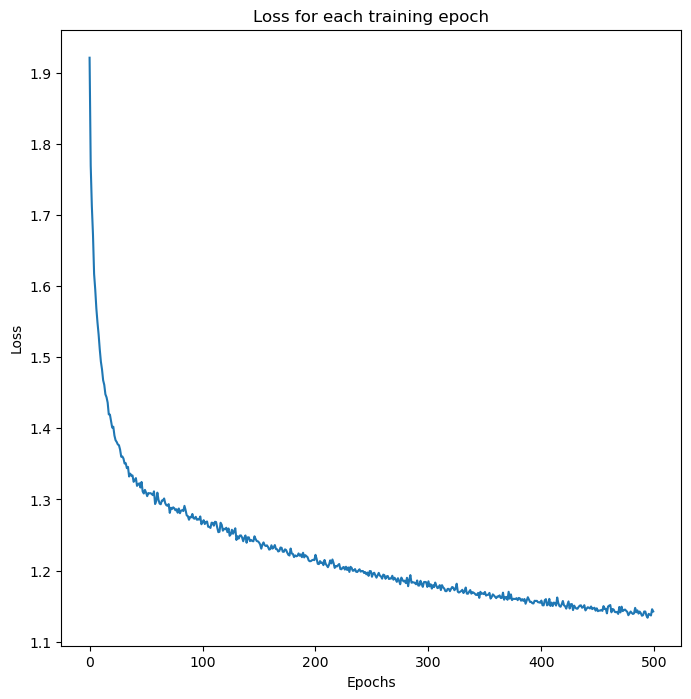

In [51]:
x_values = [i for i in range(len(losses))]
y_values = losses

plt.plot(x_values, y_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss for each training epoch')

### Trying out the trained network on the test data

In [52]:
network.eval()

NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=13, out_features=50, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=50, out_features=100, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=100, out_features=11, bias=True)
    (5): Softmax(dim=1)
  )
)

In [53]:
scores,probabilities = network.forward(X_test);
predictions = network.predict(probabilities)
print("Predictions: ", predictions)

Predictions:  tensor([ 3,  6, 10,  ...,  2, 10,  8])


In [54]:
accuracy = accuracy_score(y_test,predictions)
print("Accuracy: ", relu_accuracy)

Accuracy:  0.5208333333333334


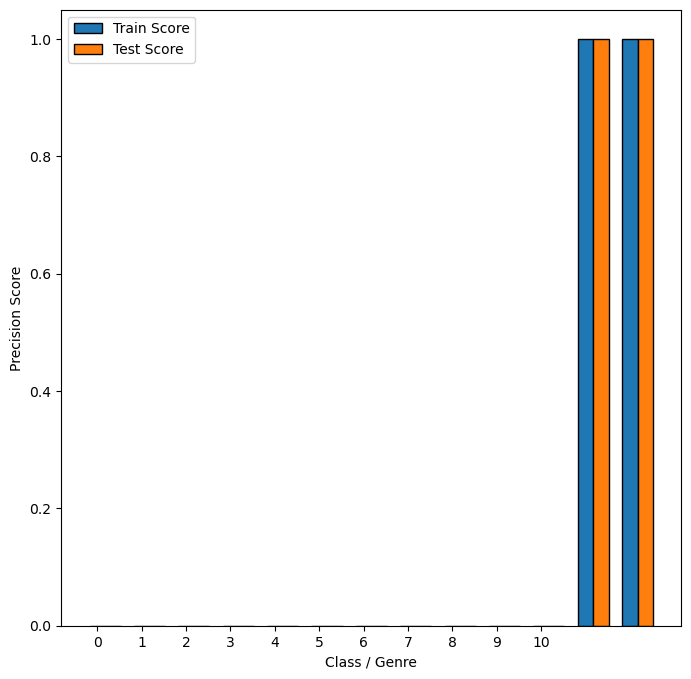

Train Avg Precision : 0.1538
Test Avg Precision : 0.1538


In [55]:
precision = get_Score(network, X_train, X_test, y_train, y_test, verbose = 1)

### Previous Network vs Tweaked Network
Here we can see that by adding another layer to the hidden layers the accuracy of the predictions got slightly better compared to having only two hidden layers.

From 52.08% to 52.19%

In [56]:
print('ReLU Accuracy: ', relu_accuracy)
print('ReLU + Adjustments: ', accuracy)

ReLU Accuracy:  0.5208333333333334
ReLU + Adjustments:  0.525


# Summary
In creating these models, we learned the following...
<ol>
    <li>

In [57]:
# Read the ver of the dataframe you want to use
# df = DataLoader('Dataset 6 - Music Dataset/music.csv', True, True).df['raw']